In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.distributions as tdist
import torch.utils.data
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.utils import save_image
from tqdm import tqdm

In [31]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2, distribution="bernoulli"):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.distribution = distribution

        # Encoder network
        # Convolutional layers for Encoder
        self.conv1 = nn.Conv2d(
            1, 32, kernel_size=4, stride=2, padding=1
        )  # Input: (batch, 1, 28, 28) -> Output: (batch, 32, 14, 14)
        self.conv2 = nn.Conv2d(
            32, 64, kernel_size=4, stride=2, padding=1
        )  # Input: (batch, 32, 14, 14) -> Output: (batch, 64, 7, 7)
        # Fully connected layers to produce mu and logvar
        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder network
        # Fully connected layer
        self.fc = nn.Linear(latent_dim, 64 * 7 * 7)
        # Transposed convolutional layers
        self.deconv1 = nn.ConvTranspose2d(
            64, 32, kernel_size=4, stride=2, padding=1
        )  # Input: (batch, 64, 7, 7) -> Output: (batch, 32, 14, 14)
        self.deconv2 = nn.ConvTranspose2d(
            32, 1, kernel_size=4, stride=2, padding=1
        )  # Input: (batch, 32, 14, 14) -> Output: (batch, 1, 28, 28)

        self.deconv3 = nn.ConvTranspose2d(
            32, 2, kernel_size=4, stride=2, padding=1
        )  # Input: (batch, 32, 14, 14) -> Output: (batch, 1, 28, 28)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # Flatten
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Standard deviation
        eps = torch.randn_like(std)  # Random tensor with same shape as std
        return mu + eps * std  # Reparameterization trick

    def decode(self, z):
        x = F.relu(self.fc(z))
        x = x.view(-1, 64, 7, 7)  # Reshape
        x = F.relu(self.deconv1(x))

        if self.distribution != "gaussian_with_learned_variance":
            x = self.deconv2(x)
            return torch.sigmoid(x)
        else:
            output = self.deconv3(x)
            # Split the output into mean and log-variance
            mu_x = output[:, 0, :, :]  # Mean of reconstructed image
            logvar_x = output[:, 1, :, :]  # Log-variance of reconstructed image
            return (torch.sigmoid(mu_x), F.softplus(logvar_x))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [3]:
# https://github.com/Robert-Aduviri/Continuous-Bernoulli-VAE
def sumlogC(x, eps=1e-5):
    """
    Numerically stable implementation of
    sum of logarithm of Continous Bernoulli
    constant C, using Taylor 2nd degree approximation

    Parameter
    ----------
    x : Tensor of dimensions (batch_size, dim)
        x takes values in (0,1)
    """
    x = torch.clamp(x, eps, 1.0 - eps)
    mask = torch.abs(x - 0.5).ge(eps)
    far = torch.masked_select(x, mask)
    close = torch.masked_select(x, ~mask)
    far_values = torch.log((torch.log(1.0 - far) - torch.log(far)).div(1.0 - 2.0 * far))
    close_values = torch.log(torch.tensor((2.0))) + torch.log(
        1.0 + torch.pow(1.0 - 2.0 * close, 2) / 3.0
    )
    return far_values.sum() + close_values.sum()


In [4]:
def sumlogC_optimized(x, eps=1e-5):
    """
    Optimized numerically stable implementation of
    sum of logarithm of Continuous Bernoulli constant C,
    using Taylor 2nd degree approximation.

    Parameters
    ----------
    x : Tensor of dimensions (batch_size, dim)
        x takes values in (0,1)
    eps : float, optional
        Small value to prevent numerical instability near 0 and 1
    """
    # Clamp x to avoid issues with log(0)
    x = torch.clamp(x, eps, 1.0 - eps)

    # Compute mask for elements far from 0.5
    mask = torch.abs(x - 0.5) >= eps

    # Precompute constants
    log2 = torch.log(torch.tensor(2.0))
    one_minus_2x = 1.0 - 2.0 * x

    # Compute 'far_values' for elements where |x - 0.5| >= eps
    numerator = torch.log1p(-x) - torch.log(x)  # log(1 - x) - log(x)
    denominator = one_minus_2x
    far_values = torch.log(numerator / denominator)

    # Compute 'close_values' using Taylor approximation for elements where |x - 0.5| < eps
    close_values = log2 + torch.log(1.0 + (one_minus_2x**2) / 3.0)

    # Use torch.where to select appropriate values based on the mask
    values = torch.where(mask, far_values, close_values)

    # Return the sum of values
    return values.sum()


In [5]:
# this can be used for VAE2, VAE20, CBVAE_Mean
def vae_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # logC = sumlogC(recon_x)
    return BCE + KLD  # , logC


In [6]:
def vae2_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD


In [7]:
def KL_divergence(mu, logvar):
    q_z = tdist.Normal(loc=mu, scale=(0.5 * logvar).exp())
    p_z = tdist.Normal(loc=torch.zeros_like(mu), scale=torch.ones_like(logvar))
    KLD = tdist.kl_divergence(q_z, p_z).sum()
    return KLD


In [8]:
def cb_lambda_loss(recon_x, x, mu, logvar):
    tmp = tdist.ContinuousBernoulli(probs=recon_x)
    recon_x = tmp.mean
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    logC = sumlogC(recon_x)
    return BCE + KLD + logC


In [9]:
def gaussian_loss(recon_x, x, mu, logvar):
    batch_size = x.size(0)
    # Flatten recon_x and x to [batch_size, 784]
    recon_x = recon_x.view(batch_size, -1)
    x = x.view(batch_size, -1)

    # Reconstruction loss (assuming a fixed variance, can use MSE)
    MSE = F.mse_loss(recon_x, x, reduction="sum")
    # MSE /= batch_size  # Normalize by batch size

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

In [10]:
# def loss_cont_gaussian(recon_x, x, mu, logvar):
#     """
#     Loss function for Gaussian vae
#     Described by https://github.com/atinghosh/VAE-pytorch/blob/master/VAE_CNN_Gaussianloss.py
#     """
#     # x = x.view(-1, 784)
#     mu_x, sigma = recon_x
#     GLL = torch.sum(torch.log(sigma)) + 0.5 * torch.sum(((x - mu_x) / sigma).pow(2))
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return KLD + GLL

In [29]:
def reconstruction_loss(x_reconstructed_mu, x_reconstructed_logvar, x_true):
    # x_true: [batch_size, height, width]
    # x_reconstructed_mu: [batch_size, height, width]
    # x_reconstructed_logvar: [batch_size, height, width]

    # Flatten the images
    x_true = x_true.view(x_true.size(0), -1)
    x_reconstructed_mu = x_reconstructed_mu.view(x_reconstructed_mu.size(0), -1)
    x_reconstructed_logvar = x_reconstructed_logvar.view(
        x_reconstructed_logvar.size(0), -1
    )

    # Compute the negative log-likelihood
    recon_loss = 0.5 * torch.sum(
        x_reconstructed_logvar
        + ((x_true - x_reconstructed_mu) ** 2) / torch.exp(x_reconstructed_logvar)
        + torch.log(torch.tensor(2) * torch.pi),  # Sum over pixels
    )
    return recon_loss  # Mean over the batch


def kl_divergence(mu_z, logvar_z):
    # mu_z and logvar_z are of shape [batch_size, latent_dim]
    kl_div = -0.5 * torch.sum(1 + logvar_z - mu_z.pow(2) - logvar_z.exp())
    return kl_div  # Mean over the batch


def loss_cont_gaussian(recon_x, x_true, mu_z, logvar_z):
    x_reconstructed_mu, x_reconstructed_logvar = recon_x
    recon_loss = reconstruction_loss(x_reconstructed_mu, x_reconstructed_logvar, x_true)
    kl_loss = kl_divergence(mu_z, logvar_z)
    return recon_loss + kl_loss

In [12]:
def beta_loss(alphas, betas, x, mu, logvar, beta_reg):
    x = x.view(-1, 784)
    recon_dist = tdist.Beta(alphas, betas)
    recon_x = recon_dist.mean
    recon_x = recon_x.view(-1, 784)
    BCE = F.binary_cross_entropy(recon_x, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD  # + logC


In [13]:
def loss_fct(recon_x, x, mu, logvar, distribution):
    if distribution == "bernoulli":
        return vae_loss(recon_x, x, mu, logvar)
    elif distribution == "continuous_bernoulli":
        return cb_lambda_loss(recon_x, x, mu, logvar)
    elif distribution == "gaussian":
        return gaussian_loss(recon_x, x, mu, logvar)
    elif distribution == "gaussian_with_learned_variance":
        return loss_cont_gaussian(recon_x, x, mu, logvar)

In [14]:
EPOCHS = 100
BATCH_SIZE = 128

torch.manual_seed(1);


## Check for GPU or MPS availability. Use CPU if neither is available


In [15]:
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using device: {device}")


Using device: mps


In [16]:
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("../data", train=True, download=True, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("../data", train=False, transform=transform),
    batch_size=BATCH_SIZE,
    shuffle=False,
)


In [17]:
def train(model, optimizer, loss_fn, epoch, distribution):
    model.train()
    train_loss = 0
    for _, (data, _) in enumerate(
        tqdm(
            train_loader,
            desc=f"Distribution: {distribution} - Training Epoch {epoch}/{EPOCHS}",
        )
    ):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_fn(recon_batch, data, mu, logvar, distribution)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    print(f"Epoch: {epoch} Average loss: {train_loss:.4f}")


In [18]:
def test(model, loss_fn, epoch, distribution):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for i, (data, _) in enumerate(
            tqdm(
                test_loader,
                desc=f"Distribution: {distribution} - Test Epoch {epoch}/{EPOCHS}",
            )
        ):
            data = data.to(device)

            recon_batch, mu, logvar = model(data)
            loss = loss_fn(recon_batch, data, mu, logvar, distribution)
            test_loss += loss

            if i == 0:
                n = min(data.size(0), 8)
                if distribution == "gaussian_with_learned_variance":
                    recon_batch = recon_batch[0]
                recon_batch = recon_batch.view(128, 1, 28, 28)
                comparison = torch.cat([data[:n], recon_batch[:n]])

                save_image(
                    comparison.cpu(),
                    f"../images/{model.distribution}/reconstruction_"
                    + str(epoch)
                    + ".png",
                    nrow=n,
                )

    test_loss /= len(test_loader.dataset)
    print(f"Test set loss: {test_loss:.4f}")


In [19]:
latent_dim = 2


In [32]:
distributions = [
    "gaussian_with_learned_variance",
    # "gaussian",
    # "bernoulli",
    # "continuous_bernoulli",
]

for distribution in distributions:
    model = VAE(latent_dim=latent_dim, distribution=distribution).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(1, EPOCHS + 1):
        train(model, optimizer, loss_fct, epoch, model.distribution)
        test(model, loss_fct, epoch, model.distribution)
        if distribution != "gaussian_with_learned_variance":
            with torch.no_grad():
                sample = torch.randn(64, latent_dim).to(device)
                sample = model.decode(sample).cpu()
                save_image(
                    sample.view(64, 1, 28, 28),
                    f"../images/{model.distribution}/sample_" + str(epoch) + ".png",
                )

    timestr = time.strftime("%Y%m%d-%H%M%S")
    torch.save(model, f"../models/{model.distribution}_{timestr}.pt")


Distribution: gaussian_with_learned_variance - Training Epoch 1/100: 100%|██████████| 469/469 [00:06<00:00, 74.12it/s]


Epoch: 1 Average loss: 756.9374


Distribution: gaussian_with_learned_variance - Test Epoch 1/100: 100%|██████████| 79/79 [00:00<00:00, 171.20it/s]


Test set loss: 745.1084


Distribution: gaussian_with_learned_variance - Training Epoch 2/100: 100%|██████████| 469/469 [00:06<00:00, 78.11it/s]


Epoch: 2 Average loss: 744.0123


Distribution: gaussian_with_learned_variance - Test Epoch 2/100: 100%|██████████| 79/79 [00:00<00:00, 184.38it/s]


Test set loss: 743.4658


Distribution: gaussian_with_learned_variance - Training Epoch 3/100: 100%|██████████| 469/469 [00:06<00:00, 76.02it/s]


Epoch: 3 Average loss: 743.2239


Distribution: gaussian_with_learned_variance - Test Epoch 3/100: 100%|██████████| 79/79 [00:00<00:00, 171.68it/s]


Test set loss: 743.0280


Distribution: gaussian_with_learned_variance - Training Epoch 4/100: 100%|██████████| 469/469 [00:06<00:00, 75.51it/s]


Epoch: 4 Average loss: 742.9330


Distribution: gaussian_with_learned_variance - Test Epoch 4/100: 100%|██████████| 79/79 [00:00<00:00, 174.38it/s]


Test set loss: 742.8679


Distribution: gaussian_with_learned_variance - Training Epoch 5/100: 100%|██████████| 469/469 [00:06<00:00, 75.22it/s]


Epoch: 5 Average loss: 742.7264


Distribution: gaussian_with_learned_variance - Test Epoch 5/100: 100%|██████████| 79/79 [00:00<00:00, 179.94it/s]


Test set loss: 742.9114


Distribution: gaussian_with_learned_variance - Training Epoch 6/100: 100%|██████████| 469/469 [00:06<00:00, 73.48it/s]


Epoch: 6 Average loss: 742.5686


Distribution: gaussian_with_learned_variance - Test Epoch 6/100: 100%|██████████| 79/79 [00:00<00:00, 163.88it/s]


Test set loss: 742.5195


Distribution: gaussian_with_learned_variance - Training Epoch 7/100: 100%|██████████| 469/469 [00:06<00:00, 74.58it/s]


Epoch: 7 Average loss: 742.4168


Distribution: gaussian_with_learned_variance - Test Epoch 7/100: 100%|██████████| 79/79 [00:00<00:00, 183.11it/s]


Test set loss: 742.3929


Distribution: gaussian_with_learned_variance - Training Epoch 8/100: 100%|██████████| 469/469 [00:06<00:00, 74.69it/s]


Epoch: 8 Average loss: 742.3105


Distribution: gaussian_with_learned_variance - Test Epoch 8/100: 100%|██████████| 79/79 [00:00<00:00, 171.73it/s]


Test set loss: 742.2642


Distribution: gaussian_with_learned_variance - Training Epoch 9/100: 100%|██████████| 469/469 [00:06<00:00, 76.28it/s]


Epoch: 9 Average loss: 742.2200


Distribution: gaussian_with_learned_variance - Test Epoch 9/100: 100%|██████████| 79/79 [00:00<00:00, 182.71it/s]


Test set loss: 742.1639


Distribution: gaussian_with_learned_variance - Training Epoch 10/100: 100%|██████████| 469/469 [00:06<00:00, 77.13it/s]


Epoch: 10 Average loss: 742.1303


Distribution: gaussian_with_learned_variance - Test Epoch 10/100: 100%|██████████| 79/79 [00:00<00:00, 184.64it/s]


Test set loss: 742.0744


Distribution: gaussian_with_learned_variance - Training Epoch 11/100: 100%|██████████| 469/469 [00:06<00:00, 76.80it/s]


Epoch: 11 Average loss: 742.0512


Distribution: gaussian_with_learned_variance - Test Epoch 11/100: 100%|██████████| 79/79 [00:00<00:00, 179.43it/s]


Test set loss: 742.0356


Distribution: gaussian_with_learned_variance - Training Epoch 12/100: 100%|██████████| 469/469 [00:06<00:00, 77.14it/s]


Epoch: 12 Average loss: 741.9861


Distribution: gaussian_with_learned_variance - Test Epoch 12/100: 100%|██████████| 79/79 [00:00<00:00, 171.06it/s]


Test set loss: 741.9844


Distribution: gaussian_with_learned_variance - Training Epoch 13/100: 100%|██████████| 469/469 [00:06<00:00, 76.34it/s]


Epoch: 13 Average loss: 741.9108


Distribution: gaussian_with_learned_variance - Test Epoch 13/100: 100%|██████████| 79/79 [00:00<00:00, 180.10it/s]


Test set loss: 741.8463


Distribution: gaussian_with_learned_variance - Training Epoch 14/100: 100%|██████████| 469/469 [00:06<00:00, 77.27it/s]


Epoch: 14 Average loss: 741.8601


Distribution: gaussian_with_learned_variance - Test Epoch 14/100: 100%|██████████| 79/79 [00:00<00:00, 178.04it/s]


Test set loss: 741.8000


Distribution: gaussian_with_learned_variance - Training Epoch 15/100: 100%|██████████| 469/469 [00:06<00:00, 76.99it/s]


Epoch: 15 Average loss: 741.8149


Distribution: gaussian_with_learned_variance - Test Epoch 15/100: 100%|██████████| 79/79 [00:00<00:00, 179.35it/s]


Test set loss: 741.7931


Distribution: gaussian_with_learned_variance - Training Epoch 16/100: 100%|██████████| 469/469 [00:06<00:00, 77.23it/s]


Epoch: 16 Average loss: 741.7880


Distribution: gaussian_with_learned_variance - Test Epoch 16/100: 100%|██████████| 79/79 [00:00<00:00, 172.47it/s]


Test set loss: 741.8387


Distribution: gaussian_with_learned_variance - Training Epoch 17/100: 100%|██████████| 469/469 [00:06<00:00, 76.38it/s]


Epoch: 17 Average loss: 741.7433


Distribution: gaussian_with_learned_variance - Test Epoch 17/100: 100%|██████████| 79/79 [00:00<00:00, 179.84it/s]


Test set loss: 741.7525


Distribution: gaussian_with_learned_variance - Training Epoch 18/100: 100%|██████████| 469/469 [00:06<00:00, 76.60it/s]


Epoch: 18 Average loss: 741.7062


Distribution: gaussian_with_learned_variance - Test Epoch 18/100: 100%|██████████| 79/79 [00:00<00:00, 180.84it/s]


Test set loss: 741.7421


Distribution: gaussian_with_learned_variance - Training Epoch 19/100: 100%|██████████| 469/469 [00:06<00:00, 76.88it/s]


Epoch: 19 Average loss: 741.6688


Distribution: gaussian_with_learned_variance - Test Epoch 19/100: 100%|██████████| 79/79 [00:00<00:00, 179.71it/s]


Test set loss: 741.6716


Distribution: gaussian_with_learned_variance - Training Epoch 20/100: 100%|██████████| 469/469 [00:06<00:00, 75.93it/s]


Epoch: 20 Average loss: 741.6295


Distribution: gaussian_with_learned_variance - Test Epoch 20/100: 100%|██████████| 79/79 [00:00<00:00, 171.31it/s]


Test set loss: 741.7161


Distribution: gaussian_with_learned_variance - Training Epoch 21/100: 100%|██████████| 469/469 [00:06<00:00, 76.13it/s]


Epoch: 21 Average loss: 741.6036


Distribution: gaussian_with_learned_variance - Test Epoch 21/100: 100%|██████████| 79/79 [00:00<00:00, 180.29it/s]


Test set loss: 741.6151


Distribution: gaussian_with_learned_variance - Training Epoch 22/100: 100%|██████████| 469/469 [00:06<00:00, 75.01it/s]


Epoch: 22 Average loss: 741.5766


Distribution: gaussian_with_learned_variance - Test Epoch 22/100: 100%|██████████| 79/79 [00:00<00:00, 179.34it/s]


Test set loss: 741.5806


Distribution: gaussian_with_learned_variance - Training Epoch 23/100: 100%|██████████| 469/469 [00:06<00:00, 75.36it/s]


Epoch: 23 Average loss: 741.5481


Distribution: gaussian_with_learned_variance - Test Epoch 23/100: 100%|██████████| 79/79 [00:00<00:00, 168.39it/s]


Test set loss: 741.5732


Distribution: gaussian_with_learned_variance - Training Epoch 24/100: 100%|██████████| 469/469 [00:06<00:00, 75.97it/s]


Epoch: 24 Average loss: 741.5190


Distribution: gaussian_with_learned_variance - Test Epoch 24/100: 100%|██████████| 79/79 [00:00<00:00, 170.37it/s]


Test set loss: 741.6365


Distribution: gaussian_with_learned_variance - Training Epoch 25/100: 100%|██████████| 469/469 [00:06<00:00, 76.73it/s]


Epoch: 25 Average loss: 741.5071


Distribution: gaussian_with_learned_variance - Test Epoch 25/100: 100%|██████████| 79/79 [00:00<00:00, 178.62it/s]


Test set loss: 741.5998


Distribution: gaussian_with_learned_variance - Training Epoch 26/100: 100%|██████████| 469/469 [00:06<00:00, 75.42it/s]


Epoch: 26 Average loss: 741.4864


Distribution: gaussian_with_learned_variance - Test Epoch 26/100: 100%|██████████| 79/79 [00:00<00:00, 179.20it/s]


Test set loss: 741.5357


Distribution: gaussian_with_learned_variance - Training Epoch 27/100: 100%|██████████| 469/469 [00:06<00:00, 76.04it/s]


Epoch: 27 Average loss: 741.4647


Distribution: gaussian_with_learned_variance - Test Epoch 27/100: 100%|██████████| 79/79 [00:00<00:00, 179.31it/s]


Test set loss: 741.6572


Distribution: gaussian_with_learned_variance - Training Epoch 28/100: 100%|██████████| 469/469 [00:06<00:00, 76.27it/s]


Epoch: 28 Average loss: 741.4296


Distribution: gaussian_with_learned_variance - Test Epoch 28/100: 100%|██████████| 79/79 [00:00<00:00, 169.30it/s]


Test set loss: 741.5220


Distribution: gaussian_with_learned_variance - Training Epoch 29/100: 100%|██████████| 469/469 [00:06<00:00, 75.36it/s]


Epoch: 29 Average loss: 741.3994


Distribution: gaussian_with_learned_variance - Test Epoch 29/100: 100%|██████████| 79/79 [00:00<00:00, 178.47it/s]


Test set loss: 741.4515


Distribution: gaussian_with_learned_variance - Training Epoch 30/100: 100%|██████████| 469/469 [00:06<00:00, 74.56it/s]


Epoch: 30 Average loss: 741.3942


Distribution: gaussian_with_learned_variance - Test Epoch 30/100: 100%|██████████| 79/79 [00:00<00:00, 179.40it/s]


Test set loss: 741.4938


Distribution: gaussian_with_learned_variance - Training Epoch 31/100: 100%|██████████| 469/469 [00:06<00:00, 75.33it/s]


Epoch: 31 Average loss: 741.3890


Distribution: gaussian_with_learned_variance - Test Epoch 31/100: 100%|██████████| 79/79 [00:00<00:00, 179.16it/s]


Test set loss: 741.4991


Distribution: gaussian_with_learned_variance - Training Epoch 32/100: 100%|██████████| 469/469 [00:06<00:00, 74.74it/s]


Epoch: 32 Average loss: 741.3571


Distribution: gaussian_with_learned_variance - Test Epoch 32/100: 100%|██████████| 79/79 [00:00<00:00, 178.58it/s]


Test set loss: 741.4562


Distribution: gaussian_with_learned_variance - Training Epoch 33/100: 100%|██████████| 469/469 [00:06<00:00, 75.04it/s]


Epoch: 33 Average loss: 741.3585


Distribution: gaussian_with_learned_variance - Test Epoch 33/100: 100%|██████████| 79/79 [00:00<00:00, 179.16it/s]


Test set loss: 741.4440


Distribution: gaussian_with_learned_variance - Training Epoch 34/100: 100%|██████████| 469/469 [00:06<00:00, 74.75it/s]


Epoch: 34 Average loss: 741.3345


Distribution: gaussian_with_learned_variance - Test Epoch 34/100: 100%|██████████| 79/79 [00:00<00:00, 171.14it/s]


Test set loss: 741.4656


Distribution: gaussian_with_learned_variance - Training Epoch 35/100: 100%|██████████| 469/469 [00:06<00:00, 74.71it/s]


Epoch: 35 Average loss: 741.3296


Distribution: gaussian_with_learned_variance - Test Epoch 35/100: 100%|██████████| 79/79 [00:00<00:00, 178.05it/s]


Test set loss: 741.4578


Distribution: gaussian_with_learned_variance - Training Epoch 36/100: 100%|██████████| 469/469 [00:06<00:00, 74.89it/s]


Epoch: 36 Average loss: 741.3046


Distribution: gaussian_with_learned_variance - Test Epoch 36/100: 100%|██████████| 79/79 [00:00<00:00, 176.41it/s]


Test set loss: 741.4200


Distribution: gaussian_with_learned_variance - Training Epoch 37/100: 100%|██████████| 469/469 [00:06<00:00, 76.15it/s]


Epoch: 37 Average loss: 741.3026


Distribution: gaussian_with_learned_variance - Test Epoch 37/100: 100%|██████████| 79/79 [00:00<00:00, 178.39it/s]


Test set loss: 741.4355


Distribution: gaussian_with_learned_variance - Training Epoch 38/100: 100%|██████████| 469/469 [00:06<00:00, 75.62it/s]


Epoch: 38 Average loss: 741.2763


Distribution: gaussian_with_learned_variance - Test Epoch 38/100: 100%|██████████| 79/79 [00:00<00:00, 163.19it/s]


Test set loss: 741.3597


Distribution: gaussian_with_learned_variance - Training Epoch 39/100: 100%|██████████| 469/469 [00:06<00:00, 75.87it/s]


Epoch: 39 Average loss: 741.2735


Distribution: gaussian_with_learned_variance - Test Epoch 39/100: 100%|██████████| 79/79 [00:00<00:00, 179.06it/s]


Test set loss: 741.3813


Distribution: gaussian_with_learned_variance - Training Epoch 40/100: 100%|██████████| 469/469 [00:06<00:00, 76.14it/s]


Epoch: 40 Average loss: 741.2457


Distribution: gaussian_with_learned_variance - Test Epoch 40/100: 100%|██████████| 79/79 [00:00<00:00, 179.66it/s]


Test set loss: 741.3766


Distribution: gaussian_with_learned_variance - Training Epoch 41/100: 100%|██████████| 469/469 [00:06<00:00, 75.60it/s]


Epoch: 41 Average loss: 741.2468


Distribution: gaussian_with_learned_variance - Test Epoch 41/100: 100%|██████████| 79/79 [00:00<00:00, 177.43it/s]


Test set loss: 741.4499


Distribution: gaussian_with_learned_variance - Training Epoch 42/100: 100%|██████████| 469/469 [00:06<00:00, 76.01it/s]


Epoch: 42 Average loss: 741.2276


Distribution: gaussian_with_learned_variance - Test Epoch 42/100: 100%|██████████| 79/79 [00:00<00:00, 170.94it/s]


Test set loss: 741.3417


Distribution: gaussian_with_learned_variance - Training Epoch 43/100: 100%|██████████| 469/469 [00:06<00:00, 75.05it/s]


Epoch: 43 Average loss: 741.2260


Distribution: gaussian_with_learned_variance - Test Epoch 43/100: 100%|██████████| 79/79 [00:00<00:00, 179.31it/s]


Test set loss: 741.3214


Distribution: gaussian_with_learned_variance - Training Epoch 44/100: 100%|██████████| 469/469 [00:06<00:00, 75.77it/s]


Epoch: 44 Average loss: 741.2278


Distribution: gaussian_with_learned_variance - Test Epoch 44/100: 100%|██████████| 79/79 [00:00<00:00, 178.89it/s]


Test set loss: 741.3666


Distribution: gaussian_with_learned_variance - Training Epoch 45/100: 100%|██████████| 469/469 [00:06<00:00, 75.06it/s]


Epoch: 45 Average loss: 741.2077


Distribution: gaussian_with_learned_variance - Test Epoch 45/100: 100%|██████████| 79/79 [00:00<00:00, 179.58it/s]


Test set loss: 741.3406


Distribution: gaussian_with_learned_variance - Training Epoch 46/100: 100%|██████████| 469/469 [00:06<00:00, 75.74it/s]


Epoch: 46 Average loss: 741.1845


Distribution: gaussian_with_learned_variance - Test Epoch 46/100: 100%|██████████| 79/79 [00:00<00:00, 171.23it/s]


Test set loss: 741.3866


Distribution: gaussian_with_learned_variance - Training Epoch 47/100: 100%|██████████| 469/469 [00:06<00:00, 75.86it/s]


Epoch: 47 Average loss: 741.1927


Distribution: gaussian_with_learned_variance - Test Epoch 47/100: 100%|██████████| 79/79 [00:00<00:00, 177.16it/s]


Test set loss: 741.3299


Distribution: gaussian_with_learned_variance - Training Epoch 48/100: 100%|██████████| 469/469 [00:06<00:00, 75.23it/s]


Epoch: 48 Average loss: 741.1777


Distribution: gaussian_with_learned_variance - Test Epoch 48/100: 100%|██████████| 79/79 [00:00<00:00, 178.64it/s]


Test set loss: 741.4684


Distribution: gaussian_with_learned_variance - Training Epoch 49/100: 100%|██████████| 469/469 [00:06<00:00, 75.44it/s]


Epoch: 49 Average loss: 741.1488


Distribution: gaussian_with_learned_variance - Test Epoch 49/100: 100%|██████████| 79/79 [00:00<00:00, 179.07it/s]


Test set loss: 741.4274


Distribution: gaussian_with_learned_variance - Training Epoch 50/100: 100%|██████████| 469/469 [00:06<00:00, 74.39it/s]


Epoch: 50 Average loss: 741.1533


Distribution: gaussian_with_learned_variance - Test Epoch 50/100: 100%|██████████| 79/79 [00:00<00:00, 169.69it/s]


Test set loss: 741.3480


Distribution: gaussian_with_learned_variance - Training Epoch 51/100: 100%|██████████| 469/469 [00:06<00:00, 75.19it/s]


Epoch: 51 Average loss: 741.1426


Distribution: gaussian_with_learned_variance - Test Epoch 51/100: 100%|██████████| 79/79 [00:00<00:00, 180.06it/s]


Test set loss: 741.3556


Distribution: gaussian_with_learned_variance - Training Epoch 52/100: 100%|██████████| 469/469 [00:06<00:00, 74.96it/s]


Epoch: 52 Average loss: 741.1385


Distribution: gaussian_with_learned_variance - Test Epoch 52/100: 100%|██████████| 79/79 [00:00<00:00, 177.63it/s]


Test set loss: 741.3126


Distribution: gaussian_with_learned_variance - Training Epoch 53/100: 100%|██████████| 469/469 [00:06<00:00, 75.23it/s]


Epoch: 53 Average loss: 741.1355


Distribution: gaussian_with_learned_variance - Test Epoch 53/100: 100%|██████████| 79/79 [00:00<00:00, 177.87it/s]


Test set loss: 741.3570


Distribution: gaussian_with_learned_variance - Training Epoch 54/100: 100%|██████████| 469/469 [00:06<00:00, 75.24it/s]


Epoch: 54 Average loss: 741.1251


Distribution: gaussian_with_learned_variance - Test Epoch 54/100: 100%|██████████| 79/79 [00:00<00:00, 170.15it/s]


Test set loss: 741.3733


Distribution: gaussian_with_learned_variance - Training Epoch 55/100: 100%|██████████| 469/469 [00:06<00:00, 74.73it/s]


Epoch: 55 Average loss: 741.1091


Distribution: gaussian_with_learned_variance - Test Epoch 55/100: 100%|██████████| 79/79 [00:00<00:00, 178.86it/s]


Test set loss: 741.3764


Distribution: gaussian_with_learned_variance - Training Epoch 56/100: 100%|██████████| 469/469 [00:06<00:00, 76.07it/s]


Epoch: 56 Average loss: 741.1287


Distribution: gaussian_with_learned_variance - Test Epoch 56/100: 100%|██████████| 79/79 [00:00<00:00, 171.84it/s]


Test set loss: 741.3113


Distribution: gaussian_with_learned_variance - Training Epoch 57/100: 100%|██████████| 469/469 [00:06<00:00, 74.88it/s]


Epoch: 57 Average loss: 741.0894


Distribution: gaussian_with_learned_variance - Test Epoch 57/100: 100%|██████████| 79/79 [00:00<00:00, 180.91it/s]


Test set loss: 741.3408


Distribution: gaussian_with_learned_variance - Training Epoch 58/100: 100%|██████████| 469/469 [00:06<00:00, 74.39it/s]


Epoch: 58 Average loss: 741.0931


Distribution: gaussian_with_learned_variance - Test Epoch 58/100: 100%|██████████| 79/79 [00:00<00:00, 169.93it/s]


Test set loss: 741.2712


Distribution: gaussian_with_learned_variance - Training Epoch 59/100: 100%|██████████| 469/469 [00:06<00:00, 74.85it/s]


Epoch: 59 Average loss: 741.0770


Distribution: gaussian_with_learned_variance - Test Epoch 59/100: 100%|██████████| 79/79 [00:00<00:00, 178.73it/s]


Test set loss: 741.3384


Distribution: gaussian_with_learned_variance - Training Epoch 60/100: 100%|██████████| 469/469 [00:06<00:00, 75.14it/s]


Epoch: 60 Average loss: 741.0752


Distribution: gaussian_with_learned_variance - Test Epoch 60/100: 100%|██████████| 79/79 [00:00<00:00, 178.21it/s]


Test set loss: 741.3214


Distribution: gaussian_with_learned_variance - Training Epoch 61/100: 100%|██████████| 469/469 [00:06<00:00, 74.70it/s]


Epoch: 61 Average loss: 741.0717


Distribution: gaussian_with_learned_variance - Test Epoch 61/100: 100%|██████████| 79/79 [00:00<00:00, 178.60it/s]


Test set loss: 741.2888


Distribution: gaussian_with_learned_variance - Training Epoch 62/100: 100%|██████████| 469/469 [00:06<00:00, 75.22it/s]


Epoch: 62 Average loss: 741.0693


Distribution: gaussian_with_learned_variance - Test Epoch 62/100: 100%|██████████| 79/79 [00:00<00:00, 170.74it/s]


Test set loss: 741.4750


Distribution: gaussian_with_learned_variance - Training Epoch 63/100: 100%|██████████| 469/469 [00:06<00:00, 75.15it/s]


Epoch: 63 Average loss: 741.0595


Distribution: gaussian_with_learned_variance - Test Epoch 63/100: 100%|██████████| 79/79 [00:00<00:00, 177.06it/s]


Test set loss: 741.3307


Distribution: gaussian_with_learned_variance - Training Epoch 64/100: 100%|██████████| 469/469 [00:06<00:00, 75.15it/s]


Epoch: 64 Average loss: 741.0574


Distribution: gaussian_with_learned_variance - Test Epoch 64/100: 100%|██████████| 79/79 [00:00<00:00, 178.93it/s]


Test set loss: 741.2762


Distribution: gaussian_with_learned_variance - Training Epoch 65/100: 100%|██████████| 469/469 [00:06<00:00, 75.35it/s]


Epoch: 65 Average loss: 741.0720


Distribution: gaussian_with_learned_variance - Test Epoch 65/100: 100%|██████████| 79/79 [00:00<00:00, 176.00it/s]


Test set loss: 741.2757


Distribution: gaussian_with_learned_variance - Training Epoch 66/100: 100%|██████████| 469/469 [00:06<00:00, 74.59it/s]


Epoch: 66 Average loss: 741.0539


Distribution: gaussian_with_learned_variance - Test Epoch 66/100: 100%|██████████| 79/79 [00:00<00:00, 169.95it/s]


Test set loss: 741.3545


Distribution: gaussian_with_learned_variance - Training Epoch 67/100: 100%|██████████| 469/469 [00:06<00:00, 75.00it/s]


Epoch: 67 Average loss: 741.0354


Distribution: gaussian_with_learned_variance - Test Epoch 67/100: 100%|██████████| 79/79 [00:00<00:00, 177.94it/s]


Test set loss: 741.4719


Distribution: gaussian_with_learned_variance - Training Epoch 68/100: 100%|██████████| 469/469 [00:06<00:00, 74.52it/s]


Epoch: 68 Average loss: 741.0358


Distribution: gaussian_with_learned_variance - Test Epoch 68/100: 100%|██████████| 79/79 [00:00<00:00, 177.47it/s]


Test set loss: 741.2628


Distribution: gaussian_with_learned_variance - Training Epoch 69/100: 100%|██████████| 469/469 [00:06<00:00, 74.32it/s]


Epoch: 69 Average loss: 741.0206


Distribution: gaussian_with_learned_variance - Test Epoch 69/100: 100%|██████████| 79/79 [00:00<00:00, 176.73it/s]


Test set loss: 741.2832


Distribution: gaussian_with_learned_variance - Training Epoch 70/100: 100%|██████████| 469/469 [00:06<00:00, 74.88it/s]


Epoch: 70 Average loss: 741.0201


Distribution: gaussian_with_learned_variance - Test Epoch 70/100: 100%|██████████| 79/79 [00:00<00:00, 171.54it/s]


Test set loss: 741.3101


Distribution: gaussian_with_learned_variance - Training Epoch 71/100: 100%|██████████| 469/469 [00:06<00:00, 70.47it/s]


Epoch: 71 Average loss: 741.0151


Distribution: gaussian_with_learned_variance - Test Epoch 71/100: 100%|██████████| 79/79 [00:00<00:00, 183.48it/s]


Test set loss: 741.3545


Distribution: gaussian_with_learned_variance - Training Epoch 72/100: 100%|██████████| 469/469 [00:06<00:00, 67.34it/s]


Epoch: 72 Average loss: 741.0139


Distribution: gaussian_with_learned_variance - Test Epoch 72/100: 100%|██████████| 79/79 [00:00<00:00, 183.02it/s]


Test set loss: 741.3002


Distribution: gaussian_with_learned_variance - Training Epoch 73/100: 100%|██████████| 469/469 [00:06<00:00, 67.69it/s]


Epoch: 73 Average loss: 741.0018


Distribution: gaussian_with_learned_variance - Test Epoch 73/100: 100%|██████████| 79/79 [00:00<00:00, 172.09it/s]


Test set loss: 741.3223


Distribution: gaussian_with_learned_variance - Training Epoch 74/100: 100%|██████████| 469/469 [00:06<00:00, 67.70it/s]


Epoch: 74 Average loss: 740.9963


Distribution: gaussian_with_learned_variance - Test Epoch 74/100: 100%|██████████| 79/79 [00:00<00:00, 182.46it/s]


Test set loss: 741.3461


Distribution: gaussian_with_learned_variance - Training Epoch 75/100: 100%|██████████| 469/469 [00:06<00:00, 67.62it/s]


Epoch: 75 Average loss: 740.9919


Distribution: gaussian_with_learned_variance - Test Epoch 75/100: 100%|██████████| 79/79 [00:00<00:00, 183.96it/s]


Test set loss: 741.2355


Distribution: gaussian_with_learned_variance - Training Epoch 76/100: 100%|██████████| 469/469 [00:06<00:00, 67.62it/s]


Epoch: 76 Average loss: 740.9861


Distribution: gaussian_with_learned_variance - Test Epoch 76/100: 100%|██████████| 79/79 [00:00<00:00, 169.14it/s]


Test set loss: 741.2087


Distribution: gaussian_with_learned_variance - Training Epoch 77/100: 100%|██████████| 469/469 [00:06<00:00, 67.37it/s]


Epoch: 77 Average loss: 740.9836


Distribution: gaussian_with_learned_variance - Test Epoch 77/100: 100%|██████████| 79/79 [00:00<00:00, 183.63it/s]


Test set loss: 741.2188


Distribution: gaussian_with_learned_variance - Training Epoch 78/100: 100%|██████████| 469/469 [00:06<00:00, 67.83it/s]


Epoch: 78 Average loss: 740.9669


Distribution: gaussian_with_learned_variance - Test Epoch 78/100: 100%|██████████| 79/79 [00:00<00:00, 175.08it/s]


Test set loss: 741.2302


Distribution: gaussian_with_learned_variance - Training Epoch 79/100: 100%|██████████| 469/469 [00:06<00:00, 68.06it/s]


Epoch: 79 Average loss: 740.9739


Distribution: gaussian_with_learned_variance - Test Epoch 79/100: 100%|██████████| 79/79 [00:00<00:00, 183.64it/s]


Test set loss: 741.3489


Distribution: gaussian_with_learned_variance - Training Epoch 80/100: 100%|██████████| 469/469 [00:06<00:00, 68.31it/s]


Epoch: 80 Average loss: 740.9555


Distribution: gaussian_with_learned_variance - Test Epoch 80/100: 100%|██████████| 79/79 [00:00<00:00, 184.20it/s]


Test set loss: 741.2732


Distribution: gaussian_with_learned_variance - Training Epoch 81/100: 100%|██████████| 469/469 [00:06<00:00, 68.96it/s]


Epoch: 81 Average loss: 740.9719


Distribution: gaussian_with_learned_variance - Test Epoch 81/100: 100%|██████████| 79/79 [00:00<00:00, 174.41it/s]


Test set loss: 741.2456


Distribution: gaussian_with_learned_variance - Training Epoch 82/100: 100%|██████████| 469/469 [00:06<00:00, 68.86it/s]


Epoch: 82 Average loss: 740.9580


Distribution: gaussian_with_learned_variance - Test Epoch 82/100: 100%|██████████| 79/79 [00:00<00:00, 179.37it/s]


Test set loss: 741.2327


Distribution: gaussian_with_learned_variance - Training Epoch 83/100: 100%|██████████| 469/469 [00:06<00:00, 67.70it/s]


Epoch: 83 Average loss: 740.9594


Distribution: gaussian_with_learned_variance - Test Epoch 83/100: 100%|██████████| 79/79 [00:00<00:00, 184.69it/s]


Test set loss: 741.2855


Distribution: gaussian_with_learned_variance - Training Epoch 84/100: 100%|██████████| 469/469 [00:06<00:00, 68.23it/s]


Epoch: 84 Average loss: 740.9647


Distribution: gaussian_with_learned_variance - Test Epoch 84/100: 100%|██████████| 79/79 [00:00<00:00, 183.08it/s]


Test set loss: 741.2905


Distribution: gaussian_with_learned_variance - Training Epoch 85/100: 100%|██████████| 469/469 [00:06<00:00, 68.65it/s]


Epoch: 85 Average loss: 740.9392


Distribution: gaussian_with_learned_variance - Test Epoch 85/100: 100%|██████████| 79/79 [00:00<00:00, 175.71it/s]


Test set loss: 741.2268


Distribution: gaussian_with_learned_variance - Training Epoch 86/100: 100%|██████████| 469/469 [00:06<00:00, 68.58it/s]


Epoch: 86 Average loss: 740.9328


Distribution: gaussian_with_learned_variance - Test Epoch 86/100: 100%|██████████| 79/79 [00:00<00:00, 186.28it/s]


Test set loss: 741.3150


Distribution: gaussian_with_learned_variance - Training Epoch 87/100: 100%|██████████| 469/469 [00:06<00:00, 68.56it/s]


Epoch: 87 Average loss: 740.9354


Distribution: gaussian_with_learned_variance - Test Epoch 87/100: 100%|██████████| 79/79 [00:00<00:00, 183.80it/s]


Test set loss: 741.3051


Distribution: gaussian_with_learned_variance - Training Epoch 88/100: 100%|██████████| 469/469 [00:06<00:00, 68.50it/s]


Epoch: 88 Average loss: 740.9236


Distribution: gaussian_with_learned_variance - Test Epoch 88/100: 100%|██████████| 79/79 [00:00<00:00, 185.05it/s]


Test set loss: 741.2057


Distribution: gaussian_with_learned_variance - Training Epoch 89/100: 100%|██████████| 469/469 [00:06<00:00, 68.05it/s]


Epoch: 89 Average loss: 740.9367


Distribution: gaussian_with_learned_variance - Test Epoch 89/100: 100%|██████████| 79/79 [00:00<00:00, 169.17it/s]


Test set loss: 741.2150


Distribution: gaussian_with_learned_variance - Training Epoch 90/100: 100%|██████████| 469/469 [00:06<00:00, 68.36it/s]


Epoch: 90 Average loss: 740.9152


Distribution: gaussian_with_learned_variance - Test Epoch 90/100: 100%|██████████| 79/79 [00:00<00:00, 181.97it/s]


Test set loss: 741.2288


Distribution: gaussian_with_learned_variance - Training Epoch 91/100: 100%|██████████| 469/469 [00:06<00:00, 67.73it/s]


Epoch: 91 Average loss: 740.9154


Distribution: gaussian_with_learned_variance - Test Epoch 91/100: 100%|██████████| 79/79 [00:00<00:00, 182.94it/s]


Test set loss: 741.2010


Distribution: gaussian_with_learned_variance - Training Epoch 92/100: 100%|██████████| 469/469 [00:07<00:00, 66.72it/s]


Epoch: 92 Average loss: 740.9215


Distribution: gaussian_with_learned_variance - Test Epoch 92/100: 100%|██████████| 79/79 [00:00<00:00, 176.02it/s]


Test set loss: 741.2363


Distribution: gaussian_with_learned_variance - Training Epoch 93/100: 100%|██████████| 469/469 [00:06<00:00, 67.34it/s]


Epoch: 93 Average loss: 740.9195


Distribution: gaussian_with_learned_variance - Test Epoch 93/100: 100%|██████████| 79/79 [00:00<00:00, 181.92it/s]


Test set loss: 741.2202


Distribution: gaussian_with_learned_variance - Training Epoch 94/100: 100%|██████████| 469/469 [00:06<00:00, 67.79it/s]


Epoch: 94 Average loss: 740.9122


Distribution: gaussian_with_learned_variance - Test Epoch 94/100: 100%|██████████| 79/79 [00:00<00:00, 182.77it/s]


Test set loss: 741.2551


Distribution: gaussian_with_learned_variance - Training Epoch 95/100: 100%|██████████| 469/469 [00:06<00:00, 68.20it/s]


Epoch: 95 Average loss: 740.9098


Distribution: gaussian_with_learned_variance - Test Epoch 95/100: 100%|██████████| 79/79 [00:00<00:00, 173.57it/s]


Test set loss: 741.2140


Distribution: gaussian_with_learned_variance - Training Epoch 96/100: 100%|██████████| 469/469 [00:06<00:00, 68.01it/s]


Epoch: 96 Average loss: 740.9098


Distribution: gaussian_with_learned_variance - Test Epoch 96/100: 100%|██████████| 79/79 [00:00<00:00, 183.72it/s]


Test set loss: 741.2434


Distribution: gaussian_with_learned_variance - Training Epoch 97/100: 100%|██████████| 469/469 [00:06<00:00, 67.64it/s]


Epoch: 97 Average loss: 740.8989


Distribution: gaussian_with_learned_variance - Test Epoch 97/100: 100%|██████████| 79/79 [00:00<00:00, 182.37it/s]


Test set loss: 741.2554


Distribution: gaussian_with_learned_variance - Training Epoch 98/100: 100%|██████████| 469/469 [00:06<00:00, 69.38it/s]


Epoch: 98 Average loss: 740.8918


Distribution: gaussian_with_learned_variance - Test Epoch 98/100: 100%|██████████| 79/79 [00:00<00:00, 176.27it/s]


Test set loss: 741.2433


Distribution: gaussian_with_learned_variance - Training Epoch 99/100: 100%|██████████| 469/469 [00:06<00:00, 69.01it/s]


Epoch: 99 Average loss: 740.9115


Distribution: gaussian_with_learned_variance - Test Epoch 99/100: 100%|██████████| 79/79 [00:00<00:00, 182.64it/s]


Test set loss: 741.2128


Distribution: gaussian_with_learned_variance - Training Epoch 100/100: 100%|██████████| 469/469 [00:06<00:00, 69.39it/s]


Epoch: 100 Average loss: 740.8976


Distribution: gaussian_with_learned_variance - Test Epoch 100/100: 100%|██████████| 79/79 [00:00<00:00, 184.81it/s]

Test set loss: 741.2595


/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_90304/840857010.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vae = torch.load("../models/bernoulli_2

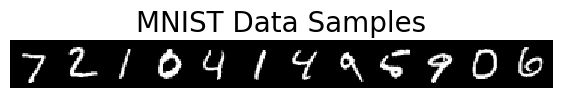

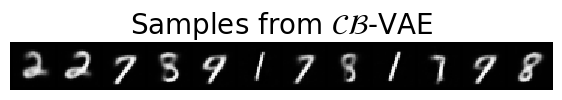

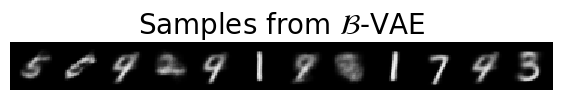

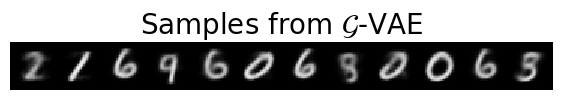

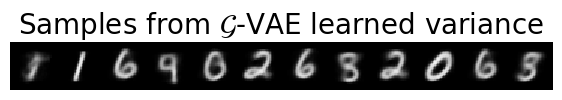

In [42]:
def imshow(img, title="MNIST Samples"):
    npimg = img.numpy()
    plt.figure(figsize=(7, 7))
    plt.title(title, fontsize=20)
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")


# Visualize dataset
dataiter = iter(test_loader)
mnist_images, mnist_labels = next(dataiter)


model_vae = VAE(latent_dim=latent_dim, distribution="bernoulli").to(device)
model_cbvae = VAE(latent_dim=latent_dim, distribution="continuous_bernoulli").to(device)
model_gvae = VAE(latent_dim=latent_dim, distribution="gaussian").to(device)
model_gvvae = VAE(
    latent_dim=latent_dim, distribution="gaussian_with_learned_variance"
).to(device)


# Load models
model_vae = torch.load("../models/bernoulli_20250105-170534.pt")
model_cbvae = torch.load("../models/continuous_bernoulli_20250105-172440.pt")
model_gvae = torch.load("../models/gaussian_20250105-180253.pt")
model_gvvae = torch.load("../models/gaussian_with_learned_variance_20250105-185346.pt")

# Sample from models
model_vae.eval()
model_cbvae.eval()
model_gvae.eval()
model_gvvae.eval()

num_samples = 12

z = torch.randn(num_samples, 2).to(device)
sample_cbvae = model_cbvae.decode(z).cpu().view(num_samples, 1, 28, 28).detach()
sample_vae = model_vae.decode(z).cpu().view(num_samples, 1, 28, 28).detach()
sample_gvae = model_gvae.decode(z).cpu().view(num_samples, 1, 28, 28).detach()


mu_x, logvar_x = model_gvvae.decode(z)
# Step 3: Sample x ~ N(μ_x, diag(σ_x^2))
std_x = torch.exp(0.5 * logvar_x)
eps = torch.randn_like(logvar_x)
x_sampled = mu_x + eps * logvar_x
# x_sampled = torch.sigmoid(x_sampled)
sample_gvvae = x_sampled.cpu().view(num_samples, 1, 28, 28).detach()

# Plot

imshow(
    torchvision.utils.make_grid(mnist_images[:num_samples], num_samples),
    r"MNIST Data Samples",
)
imshow(
    torchvision.utils.make_grid(sample_cbvae[:num_samples], num_samples),
    r"Samples from $\mathcal{CB}$-VAE",
)
imshow(
    torchvision.utils.make_grid(sample_vae[:num_samples], num_samples),
    r"Samples from $\mathcal{B}$-VAE",
)
imshow(
    torchvision.utils.make_grid(sample_gvae[:num_samples], num_samples),
    r"Samples from $\mathcal{G}$-VAE",
)
imshow(
    torchvision.utils.make_grid(sample_gvvae[:num_samples], num_samples),
    r"Samples from $\mathcal{G}$-VAE learned variance",
)